# EDA
## Explore the data with some EDA
First, let's explore the data. Any time we begin a machine learning (ML) project, we need to first do some exploratory data analysis (EDA) to familiarize ourselves with the data. This includes things like:

- raw data plots
- histograms
- and more... 

I typically begin with raw data plots and histograms. This allows us to understand our data's distributions. If it's a normal distribution, we can use things like parametric statistics.

There are two stocks loaded for you into pandas DataFrames: `lng_df` and `spy_df` (LNG and SPY). Take a look at them with `.head()`. We'll use the closing prices and eventually volume as inputs to ML algorithms.

Note: We'll call `plt.clf()` each time we want to make a new plot, or `f = plt.figure()`.

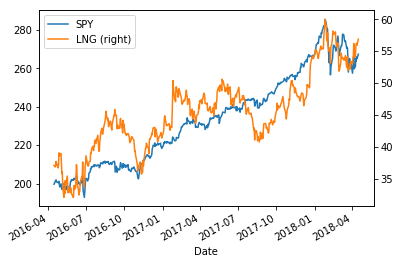

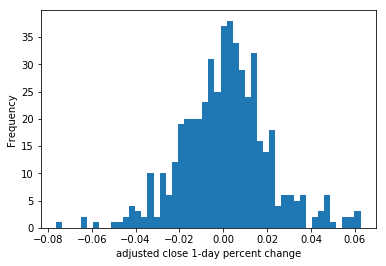

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

lng_df_tmp = pd.read_csv('data/LNG.csv', index_col=0, parse_dates=[0])
spy_df_tmp = pd.read_csv('data/SPY.csv', index_col=0, parse_dates=[0])

lng_df = lng_df_tmp.loc['2016-04-15':'2018-04-16', :]
spy_df = spy_df_tmp.loc['2016-04-15':'2018-04-16', :]

# Plot the Adj_Close columns for SPY and LNG
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()  # show the plot
#plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for LNG
lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

# Data transforms, features, and targets
## Correlations
Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.161757
5d_close_future_pct     -0.161757             1.000000


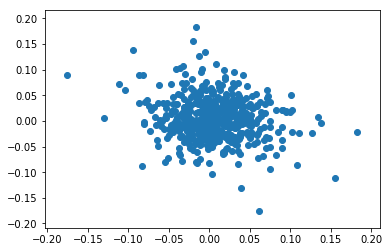

In [3]:
# Create the 5-day future price (as 5d_future_close) with pandas' .shift().
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)

# Use pct_change() on 5d_future_close and Adj_Close to create the % price change 5 days in the future (5d_close_future_pct),
# and the current 5-day % price change (5d_close_pct).
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

## Create moving average and RSI features
We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.

A moving average is one of the simplest indicators - it's the average of previous data points. This is the function talib.SMA() from the TAlib library.

Another common technical indicator is the relative strength index (RSI). This is defined by:

RSI= $100 − \frac {100} {1+RS}$ 

RS = $ \frac {\text{average gain over n periods}}{\text{average loss over n periods}}$ 

The n periods is set in talib.RSI() as the timeperiod argument.

A common period for RSI is 14, so we'll use that as one setting in our calculations.

In [4]:
import talib

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

ModuleNotFoundError: No module named 'talib'

## Create features and targets
We almost have features and targets that are machine-learning ready -- we have features from current price changes `(5d_close_pct)` and indicators (moving averages and RSI), and we created targets of future price changes `(5d_close_future_pct)`. Now we need to break these up into separate numpy arrays so we can feed them into machine learning algorithms.

Our indicators also cause us to have missing values at the beginning of the DataFrame due to the calculations. We could backfill this data, fill it with a single value, or drop the rows. Dropping the rows is a good choice, so our machine learning algorithms aren't confused by any sort of backfilled or 0-filled data. Pandas has a `.dropna()` function which we will use to drop any rows with missing values.

In [49]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; 5d_close_future_pct for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feat_targ_df = lng_df[['5d_close_future_pct'] + feature_names]

# Calculate correlation matrix
corr = feat_targ_df.corr()
display(corr)

,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
5d_close_future_pct,1.000000,-0.041492,0.090935,-0.069626,0.101411,-0.108816,0.117967,-0.140346,0.224858,-0.217574
5d_close_pct,-0.041492,1.000000,-0.829619,0.682032,-0.609793,0.514619,-0.468384,0.423649,-0.226752,0.287883
ma14,0.090935,-0.829619,1.000000,-0.875512,0.847993,-0.709461,0.686156,-0.599337,0.350627,-0.418730
rsi14,-0.069626,0.682032,-0.875512,1.000000,-0.964679,0.935305,-0.915149,0.845702,-0.551204,0.639451
ma30,0.101411,-0.609793,0.847993,-0.964679,1.000000,-0.899955,0.923275,-0.805039,0.528831,-0.600994
rsi30,-0.108816,0.514619,-0.709461,0.935305,-0.899955,1.000000,-0.962582,0.975589,-0.759454,0.833239
ma50,0.117967,-0.468384,0.686156,-0.915149,0.923275,-0.962582,1.000000,-0.915291,0.689646,-0.748179
rsi50,-0.140346,0.423649,-0.599337,0.845702,-0.805039,0.975589,-0.915291,1.000000,-0.869838,0.929494
ma200,0.224858,-0.226752,0.350627,-0.551204,0.528831,-0.759454,0.689646,-0.869838,1.000000,-0.975946
rsi200,-0.217574,0.287883,-0.418730,0.639451,-0.600994,0.833239,-0.748179,0.929494,-0.975946,1.000000


## Check the correlations
Before we fit our first machine learning model, let's look at the correlations between features and targets. Ideally we want large (near 1 or -1) correlations between features and targets. Examining correlations can help us tweak features to maximize correlation (for example, altering the `timeperiod` argument in the `talib` functions). It can also help us remove features that aren't correlated to the target.

To easily plot a correlation matrix, we can use `seaborn`'s `heatmap()` function. This takes a correlation matrix as the first argument, and has many other options. Check out the annot option -- this will help us turn on annotations.

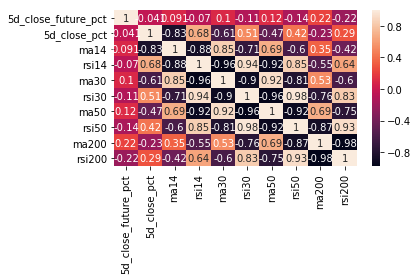

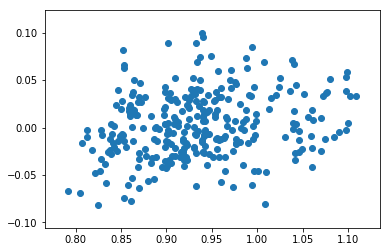

In [50]:
import seaborn as sns
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(lng_df['ma200'], lng_df['5d_close_future_pct'])
plt.show()

# Linear Modeling with financial data
## Create train and test features
Before we fit our linear model, we want to add a constant to our features, so we have an intercept for our linear model.

We also want to create train and test features. This is so we can fit our model to the train dataset, and evaluate performance on the test dataset. We always want to check performance on data the model has not seen to make sure we're not overfitting, which is memorizing patterns in the training data too exactly.

With a time series like this, we typically want to use the oldest data as our training set, and the newest data as our test set. This is so we can evaluate the performance of the model on the most recent data, which will more realistically simulate predictions on data we haven't seen yet.


In [51]:
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(299, 10) (254, 10) (45, 10)


## Fit a linear model
We'll now fit a linear model, because they are simple and easy to understand. Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, as well as their magnitude of effect on the target. Our judgment of whether or not predictors are significant is based on the p-values of coefficients. This is using a t-test to statistically test if the coefficient significantly differs from 0. The p-value is the percent chance that the coefficient for a feature does not differ from zero. Typically, we take a p-value of less than 0.05 to mean the coefficient is significantly different from 0.

In [52]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()   # fit the model
print(results.summary()) # Print out the results summary
      
# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.219
Model:                             OLS   Adj. R-squared:                  0.190
Method:                  Least Squares   F-statistic:                     7.591
Date:                 Sun, 30 Sep 2018   Prob (F-statistic):           8.30e-10
Time:                         18:55:46   Log-Likelihood:                 531.72
No. Observations:                  254   AIC:                            -1043.
Df Residuals:                      244   BIC:                            -1008.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.4733      1.209    

## Evaluate our results
Once we have our linear fit and predictions, we want to see how good the predictions are so we can decide if our model is any good or not. Ideally, we want to back-test any type of trading strategy. However, this is a complex and typically time-consuming experience.

A quicker way to understand the performance of our model is looking at regression evaluation metrics like $R^2$, and plotting the predictions versus the actual values of the targets. Perfect predictions would form a straight, diagonal line in such a plot, making it easy for us to eyeball how our predictions are doing in different regions of price changes. We can use `matplotlib`'s `.scatter()` function to create scatter plots of the predictions and actual values.

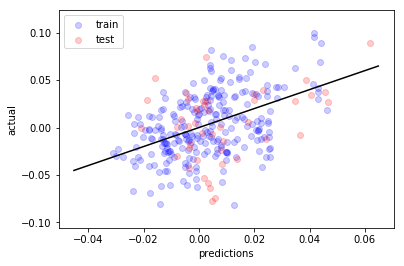

In [53]:
import numpy as np
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()